# Final Project Classification

## 주제: 항생제 감수성 예측 (내성)


- Classification 수행


```
Introduction

응급 환자에게 있어서, 항생제 감수성 여부는 중요한 요소이다.
응급한 상황에서 순서대로 항생제 1차, 2차, 3차를 투여하기에는 위험 부담이 크다. 감수성 여부를 따지지않고 높은 차수의 항생제를 투여하면,
지역 항생제 감수성이 만연하게 될 것이다.또한 3차 항생제의 부작용은 크기에 주의가 필요하다.

그래서, 환자의 감수성을 예측하는 것이 중요하다.
환자의 감수성에 맞춰 1차,2차 항생제를 투여하고,  3차 항생제를 투여하지않는다면 많은 부담을 줄일 수 있을 것이다. 그리고 응급환자에게 있어서 매우 효율적일 것이다.

항생제중 ciprofloxacin(CIP) 감수성 여부가 target이다. (0 : 감수성 , 1 : 내성)
CIP를 치료로 이용하는 병균 감염에는 뼈 및 관절염, 복강내 전염, 특정한 종류의 장염, 호흡기 감염, 피부 감염, 장티푸스, 요로감염증 등이 포함된다.

알려진 주요 가설은 다른 병원에 오래 있거나 고령, 침상 환자들은 지속적으로 항생제를 투여해서, 감수성이 있을것이란 것이다.

 

```

- 과제의 목표
- 여러가지 다변량 분석 방법을 수행하고 결과들을 비교해본다.
    - PCA + MCA를 통해 수치형 범주형 변수를 나눠서 분석
    - PCA만을 이용해 범주형,수치형 모두 분석 
    - 둘간의 결과 비교
    - Factor analysis
- 다변량 분석결과를 통해 변수 변환을 거쳐서 분류 분석을 실시한다.

## 목표:

이 노트북에서는 EDA를 통해 얻어진 변수들로, LDA 및 QDA를 수행한다.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import sys

import scipy.stats as stats # qqplot에 사용
import prince #MCA

In [8]:
#시각화 패키지들
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
from statsmodels.graphics.mosaicplot import mosaic

plt.style.use("ggplot")


In [9]:
#분석 관련
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from statsmodels.formula.api import ols
from factor_analyzer import FactorAnalyzer

# 데이터 로드

In [10]:
X_train = pd.read_excel("../data/cip_clean.xlsx")
Y_train = pd.read_excel("../data/cip_clean_y.xlsx")
print(X_train.shape)
print(Y_train.shape)
X_train.head()

(374, 20)
(374, 1)


,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,sex,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
0,65,35.3,36.7,93.8,10.4,164,166.776760,-54.648970,-6.243187,1,1,1,1,0,0,0,1,1,0,0
1,59,36.6,45.0,96.6,7.7,285,231.514181,-124.984006,-15.465952,1,1,0,1,0,0,0,1,1,0,0
2,95,39.6,28.1,96.0,12.2,254,236.912513,-92.838756,-1.204840,0,0,0,0,0,0,0,1,0,0,0
3,77,36.9,29.0,97.3,10.5,90,132.916080,-9.785243,2.413314,1,0,0,0,0,1,1,0,0,1,0
4,79,39.1,31.3,92.8,11.5,298,250.409276,-123.525452,-4.525291,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_test = pd.read_excel("../data/cip_clean_test.xlsx")
Y_test = pd.read_excel("../data/cip_clean_test_y.xlsx")
print(X_test.shape)
print(Y_test.shape)
X_test.head()

(94, 20)
(94, 1)


,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,sex,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
0,58,39.1,30.8,94.7,13.1,191,177.200813,-71.027662,1.267048,1,0,0,0,0,0,0,0,0,0,0
1,82,39.4,40.4,93.2,14.0,194,199.373424,-63.466209,-8.335625,0,0,0,0,0,1,1,0,0,1,0
2,69,38.2,34.2,94.5,13.4,236,210.373936,-91.179250,-4.136335,1,0,0,0,0,0,0,0,0,0,1
3,50,38.6,33.5,91.9,12.1,152,150.637294,-53.530863,0.017585,0,0,0,0,0,0,0,0,0,0,0
4,68,39.4,32.6,94.7,11.5,129,150.648831,-34.717581,0.533184,1,0,0,0,0,0,0,0,0,0,0


In [12]:
X_train[[ 'sex','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']]=X_train[[ 'sex','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].astype('category')

In [13]:
X_test[[ 'sex','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']]=X_test[[ 'sex','bed','Foley','Nursing','Hsp-acq','3m-Ab','3m-Adm','NR','1y-UTI','PPIantacid','CV']].astype('category')

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   iDBP        374 non-null    int64   
 1   iBT         374 non-null    float64 
 2   pCO2        374 non-null    float64 
 3   SaO2        374 non-null    float64 
 4   Hb          374 non-null    float64 
 5   Plt         374 non-null    int64   
 6   factor1     374 non-null    float64 
 7   factor2     374 non-null    float64 
 8   factor3     374 non-null    float64 
 9   sex         374 non-null    category
 10  bed         374 non-null    category
 11  Foley       374 non-null    category
 12  Nursing     374 non-null    category
 13  Hsp-acq     374 non-null    category
 14  3m-Ab       374 non-null    category
 15  3m-Adm      374 non-null    category
 16  NR          374 non-null    category
 17  1y-UTI      374 non-null    category
 18  PPIantacid  374 non-null    category
 19  CV      

In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   iDBP        94 non-null     int64   
 1   iBT         94 non-null     float64 
 2   pCO2        94 non-null     float64 
 3   SaO2        94 non-null     float64 
 4   Hb          94 non-null     float64 
 5   Plt         94 non-null     int64   
 6   factor1     94 non-null     float64 
 7   factor2     94 non-null     float64 
 8   factor3     94 non-null     float64 
 9   sex         94 non-null     category
 10  bed         94 non-null     category
 11  Foley       94 non-null     category
 12  Nursing     94 non-null     category
 13  Hsp-acq     94 non-null     category
 14  3m-Ab       94 non-null     category
 15  3m-Adm      94 non-null     category
 16  NR          94 non-null     category
 17  1y-UTI      94 non-null     category
 18  PPIantacid  94 non-null     category
 19  CV        

In [17]:
# 데이터 normalize

from sklearn.preprocessing import MinMaxScaler

numerics = ['iDBP','iBT','pCO2','SaO2','Hb','Plt','factor1','factor2','factor3']

sc = MinMaxScaler()

X_train[numerics] = sc.fit_transform(X_train[numerics])
X_test[numerics] = sc.transform(X_test[numerics])

In [18]:
X_train.head()

,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,sex,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
0,0.311321,0.011491,0.546460,0.067210,0.022814,0.184143,0.171898,0.682201,0.100909,1,1,1,1,0,0,0,1,1,0,0
1,0.254717,0.015135,0.730088,0.070211,0.009981,0.338875,0.317675,0.546490,0.059047,1,1,0,1,0,0,0,1,1,0,0
2,0.594340,0.023543,0.356195,0.069568,0.031369,0.299233,0.329831,0.608514,0.123778,0,0,0,0,0,0,0,1,0,0,0
3,0.424528,0.015975,0.376106,0.070962,0.023289,0.089514,0.095651,0.768765,0.140201,1,0,0,0,0,1,1,0,0,1,0
4,0.443396,0.022141,0.426991,0.066138,0.028042,0.355499,0.360223,0.549305,0.108706,0,0,0,0,0,0,0,0,0,0,0


In [19]:
X_test.head()

,iDBP,iBT,pCO2,SaO2,Hb,Plt,factor1,factor2,factor3,sex,bed,Foley,Nursing,Hsp-acq,3m-Ab,3m-Adm,NR,1y-UTI,PPIantacid,CV
0,0.245283,0.022141,0.415929,0.068175,0.035646,0.218670,0.195371,0.650598,0.134998,1,0,0,0,0,0,0,0,0,0,0
1,0.471698,0.022982,0.628319,0.066567,0.039924,0.222506,0.245300,0.665188,0.091411,0,0,0,0,0,1,1,0,0,1,0
2,0.349057,0.019619,0.491150,0.067960,0.037072,0.276215,0.270071,0.611716,0.110472,1,0,0,0,0,0,0,0,0,0,1
3,0.169811,0.020740,0.475664,0.065173,0.030894,0.168798,0.135555,0.684358,0.129327,0,0,0,0,0,0,0,0,0,0,0
4,0.339623,0.022982,0.455752,0.068175,0.028042,0.139386,0.135581,0.720658,0.131667,1,0,0,0,0,0,0,0,0,0,0


# LDA

- 참고 : https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-18-%EC%84%A0%ED%98%95%ED%8C%90%EB%B3%84%EB%B6%84%EC%84%9DLDA

train set 분류결과 : 
 [[145  56]
 [ 41 132]]


C:\Users\dlwhd\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


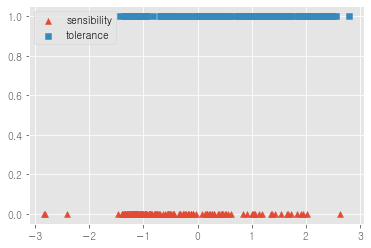

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

# 2개의 클래스로 구분하기 위한 LDA 생성

lda = LinearDiscriminantAnalysis()# .이진분류라서, component를 하나만 이용

# fit()호출 시 target값 입력  (지도학습)
lda.fit(X_train, Y_train)
train_lda = lda.transform(X_train)

lda_columns=['lda_component_1',]
trainDF_lda = pd.DataFrame(train_lda, columns=lda_columns)
trainDF_lda['target']=Y_train


markers=['^', 's',]
target_names=['sensibility','tolerance']

for i, marker in enumerate(markers):
    x_axis_data = trainDF_lda[trainDF_lda['target']==i]['lda_component_1']

    plt.scatter(x_axis_data,[i]*len(x_axis_data), marker=marker, label=target_names[i])
plt.legend()
print("train set 분류결과 : \n",confusion_matrix(lda.predict(X_train),Y_train))


x축(lda1 component)을 통해 분류하는 상황이다.

LDA를 통해서는 Trainset도 구별이 어려워 보인다.

또한, Factor 변수들을 추가시켜도 결과는 같다.

In [21]:
confs=confusion_matrix(lda.predict(X_test),Y_test)
print("Test set LDA 결과")
print(confs)
accuracy =  (confs[0,0]+confs[1,1])/confs.sum()
print(" accuracy: {:.4f}".format(accuracy))
p = precision_score(lda.predict(X_test),Y_test)
print(" precision: {:.4f}".format(p))
r = recall_score(lda.predict(X_test),Y_test)
print(" recall: {:.4f}".format(r))
f1 = f1_score(lda.predict(X_test),Y_test)
print(" f1: {:.4f}".format(f1))



Test set LDA 결과
[[38 21]
 [ 9 26]]
 accuracy: 0.6809
 precision: 0.5532
 recall: 0.7429
 f1: 0.6341


# QDA

In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

# 2개의 클래스로 구분하기 위한 LDA 생성

qda = QuadraticDiscriminantAnalysis()# .이진분류라서, component를 하나만 이용

# fit()호출 시 target값 입력  (지도학습)
qda.fit(X_train, Y_train)
#train_qda = qda.transform(X_train)

print("train set 분류결과 : \n",confusion_matrix(qda.predict(X_train),Y_train))


train set 분류결과 : 
 [[ 48  30]
 [138 158]]


C:\Users\dlwhd\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\dlwhd\AppData\Roaming\Python\Python37\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [26]:
confs=confusion_matrix(qda.predict(X_test),Y_test)
print("Test set QDA 결과")
print(confs)
accuracy =  (confs[0,0]+confs[1,1])/confs.sum()
print(" accuracy: {:.4f}".format(accuracy))
p = precision_score(qda.predict(X_test),Y_test)
print(" precision: {:.4f}".format(p))
r = recall_score(qda.predict(X_test),Y_test)
print(" recall: {:.4f}".format(r))
f1 = f1_score(qda.predict(X_test),Y_test)
print(" f1: {:.4f}".format(f1))



Test set QDA 결과
[[16  7]
 [31 40]]
 accuracy: 0.5957
 precision: 0.8511
 recall: 0.5634
 f1: 0.6780


QDA에서는 더 떨어지는 결과를 보인다.

현재 데이터가 범주형 자료에 큰 중요성이 있어서, 수치형 다변량 자료에 쓰이는 LDA , QDA로는 결과를 내기 어렵다.

추후 다른 Tree 계열의 방법들로 분류를 시도할 예정이다.